# Case Study: Write a classification model for Python Exceptions
---

In [2]:
import os
os.chdir('..')
print(f'Setting working dir to: {os.getcwd()}')

Setting working dir to: /Users/ingomarquart/Documents/GitHub/itern-nlp-training-cases


In [3]:
!mkdir -p ../checkpoints
!mkdir -p ../logs

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer

In [5]:
def print_outputinfo(output):
  """
  A quick function to help print outputs
  Will be used later on 
  """
  fields = list(output.keys())
  message = f"Model returns a: {type(output)} \n with fields {output.keys()} \n with dimensions"
  for field in fields:
    if torch.is_tensor(output[field]):
      message += f"\n {output[field].shape} for {field} " 
    elif hasattr(output[field], "__len__"):
      message += f"\n {len(output[field])} for {field} " 
  print(message)

## Text Classification

In this notebook, we will work with a BERT derivative to classify errors in Python Code. 

A broad overview of tasks:


*   Download the data, analyze it and prepare a Dataset
*   Deal with slightly more complex text data and tokenize it
*   Use a transformer model to extract features for each code snippet and visualize them
*   Create a feature extraction pipeline, and train a simple logit model
*  End-to-end fine-tune a transformer model to predict error types in code






### Exercise 1: Load the Dataset

The dataset is saved on the Huggingface Hub. There are training and validation splits, which we will use as well.   
- Download the dataset
- Remove the columns `Unnamed: 0` from the dataset

In [6]:
dataset_name = "statworx/Py150ExceptionClassification"

# Add your solution here:
# ...

#### Solution

In [7]:
# Load data from hub and remove unwanted column
dataset = load_dataset(dataset_name)
dataset = dataset.remove_columns("Unnamed: 0")

Using custom data configuration statworx--Py150ExceptionClassification-8cb8951e088709d2
Reusing dataset csv (/Users/ingomarquart/.cache/huggingface/datasets/statworx___csv/statworx--Py150ExceptionClassification-8cb8951e088709d2/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)


  0%|          | 0/2 [00:00<?, ?it/s]

### Exercise 2: Explore the Data

Print some examples to get a better feel for the data.

In [8]:
# Add your solution here:
# ...

#### Solution

In [9]:
# Print the first 2 examples from the dataset with the function source code and associated label
for idx in range(0, 2):
  print(f'------ \n Code: \n {dataset["train"][idx]["function"]} \n Label: {dataset["train"][idx]["label"]} \n\n')

------ 
 Code: 
 def run(self):
        """
        Called when the process intializes.
        """
        logger.info('started worker')

        FULL_NAMESPACE = settings.FULL_NAMESPACE
        MINI_NAMESPACE = settings.MINI_NAMESPACE
        MAX_RESOLUTION = settings.MAX_RESOLUTION
        full_uniques = FULL_NAMESPACE + 'unique_metrics'
        mini_uniques = MINI_NAMESPACE + 'unique_metrics'
        pipe = self.redis_conn.pipeline()

        while 1:

            # Make sure Redis is up
            try:
                self.redis_conn.ping()
            except:
                logger.error('worker can\'t connect to redis at socket path %s' % settings.REDIS_SOCKET_PATH)
                sleep(10)
                self.redis_conn = StrictRedis(unix_socket_path = settings.REDIS_SOCKET_PATH)
                pipe = self.redis_conn.pipeline()
                continue

            try:
                # Get a chunk from the queue with a 15 second timeout
                chunk = self.q.get(

### Exercise 3: Preparing Feasible Labels


There are a number of Python Errors in this dataset. We need to find out:

* How many there are in total?
* How many examples there is for each error?

If there are many different errors, some with only few examples, we will want to delete them!

Delete any label with less than 1500 observations


In [10]:
# Add your solution here:
# ...

#### Solution

In [11]:
# Count the number of examples for each label
label_counts = pd.DataFrame(np.unique(dataset["train"]["label"], return_counts = True)).T.set_index([0])
label_counts.columns = ["counts"]
print(label_counts.sort_values(by="counts", ascending=False))

# And remove labels based on counts
keep_labels = np.array(label_counts.index[label_counts.counts >= 1500])
print(keep_labels)
filtered_dataset = dataset.filter(lambda x: x["label"] in keep_labels)
print(f"Reduced dataset by removing {len(label_counts)-len(keep_labels)} labels, reducing from {dataset.shape['train'][0]} examples to {filtered_dataset.shape['train'][0]} examples")

Loading cached processed dataset at /Users/ingomarquart/.cache/huggingface/datasets/statworx___csv/statworx--Py150ExceptionClassification-8cb8951e088709d2/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-68b93c1f2171e9d7.arrow
Loading cached processed dataset at /Users/ingomarquart/.cache/huggingface/datasets/statworx___csv/statworx--Py150ExceptionClassification-8cb8951e088709d2/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-b61482612d425db9.arrow


                    counts
0                         
ValueError            3417
KeyError              3384
AttributeError        2444
TypeError             1564
OSError               1396
IOError               1318
ImportError           1180
IndexError            1035
KeyboardInterrupt      509
StopIteration          432
AssertionError         323
RuntimeError           247
NotImplementedError    206
SystemExit             200
ObjectDoesNotExist     197
UnicodeDecodeError     196
NameError              166
ValidationError        159
HTTPError              104
DoesNotExist             3
['AttributeError' 'KeyError' 'TypeError' 'ValueError']
Reduced dataset by removing 16 labels, reducing from 18480 examples to 10809 examples


### Exercise 4: Create Two Dictionaries for Labeling

For later use, create two Python dictionaries as lookup tables.
One takes a label (e.g. `'AttributeError'`) and gives a numerical id (e.g. `0`).
The other reverses this operation.

In [12]:
# Add your solution here:
# ...

#### Solution

In [13]:
# Simple lookup dicts
lidx_to_label = {i:keep_labels[i] for i in range(0, len(keep_labels))}
label_to_lidx = {keep_labels[i]:i for i in range(0, len(keep_labels))}

label_to_lidx

{'AttributeError': 0, 'KeyError': 1, 'TypeError': 2, 'ValueError': 3}

### Exercise 5: Treat Outliers in the Length of Code Snippets


Each batch going into the transformer model needs a fixed sequence length. For that reason, our Trainer or DataCollator will pad other sequences to the length of the longest one in the batch.

This is a problem if we have a few very long sentences - in that case, such a sample would become very large and likely (and possibly at any point in the training) overload our GPU or CPU.

Visualize the length of the code snippets by using a histogram, and **then cut those from the dataset that have more than 3000 characters.**

In [14]:
# Add your solution here:
# ...

#### Solution

Loading cached processed dataset at /Users/ingomarquart/.cache/huggingface/datasets/statworx___csv/statworx--Py150ExceptionClassification-8cb8951e088709d2/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-8868e0f6d86bebba.arrow
Loading cached processed dataset at /Users/ingomarquart/.cache/huggingface/datasets/statworx___csv/statworx--Py150ExceptionClassification-8cb8951e088709d2/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-4e64b5d5a5227e02.arrow


(array([7.21167715e-05, 1.67339826e-07, 4.68551514e-08, 6.69359305e-09,
       0.00000000e+00, 6.69359305e-09, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.69359305e-09]), array([8.300000e+01, 1.390450e+04, 2.772600e+04, 4.154750e+04,
       5.536900e+04, 6.919050e+04, 8.301200e+04, 9.683350e+04,
       1.106550e+05, 1.244765e+05, 1.382980e+05]), <BarContainer object of 10 artists>)
Reduced dataset by removing long sequences, reducing from 10809 examples to 9991 examples
(array([9.65178887e-04, 8.41526076e-04, 5.20372247e-04, 3.53440952e-04,
       2.33909901e-04, 1.66587815e-04, 1.36705052e-04, 9.03352482e-05,
       7.14438465e-05, 5.22089647e-05]), array([  83. ,  374.4,  665.8,  957.2, 1248.6, 1540. , 1831.4, 2122.8,
       2414.2, 2705.6, 2997. ]), <BarContainer object of 10 artists>)


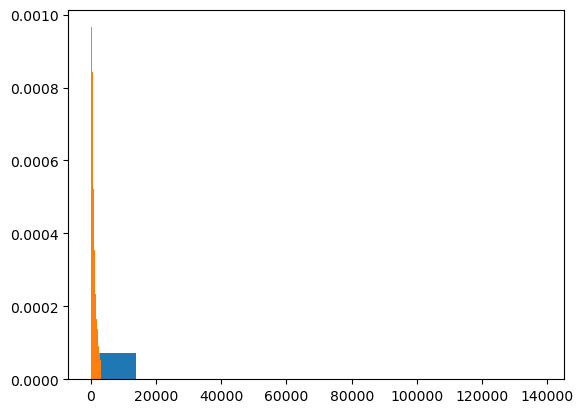

In [15]:
# Extract the length of the code and visualize the distribution
lengths = pd.DataFrame({"tokens": [len(x["function"].split()) for x in filtered_dataset["train"]], 
                        "chars": [len(x["function"]) for x in filtered_dataset["train"]]})

print(plt.hist(lengths["chars"], density=True))

# Filter dataset
n_filtered_dataset = filtered_dataset.filter(lambda x: len(x['function']) < 3000)
print(f"Reduced dataset by removing long sequences, reducing from {filtered_dataset.shape['train'][0]} examples to {n_filtered_dataset.shape['train'][0]} examples")

# Make sure it worked
lengths = pd.DataFrame({"tokens": [len(x["function"].split()) for x in n_filtered_dataset["train"]], 
                        "chars": [len(x["function"]) for x in n_filtered_dataset["train"]]})

print(plt.hist(lengths["chars"], density=True))

### Exercise 6: Shuffle, then Sample the Dataset

For a quick illustration, the dataset is a bit too large.
Let's half it.

Furthermore, we have an extraordinarily large test set - it is as large as the training dataset.

This is not necessary and will make validation very costly. 

Shuffle the dataset, then reduce the sample size of testing dataset

#### Solution

In [16]:
# Shuffe the dataset and then take every second example
# As an alternative, directly use data[split].sample(frac=0.5)
n_filtered_dataset = n_filtered_dataset.shuffle(seed=42)
n_filtered_dataset = n_filtered_dataset.filter(lambda example, idx: idx % 2 == 0, with_indices=True)

downsampled_test = n_filtered_dataset["test"].filter(lambda example, idx: idx % 5 == 0, with_indices=True)

n_filtered_dataset["test"] = downsampled_test
n_filtered_dataset = n_filtered_dataset.shuffle(seed=42)

Loading cached shuffled indices for dataset at /Users/ingomarquart/.cache/huggingface/datasets/statworx___csv/statworx--Py150ExceptionClassification-8cb8951e088709d2/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-1abb78481cd3e382.arrow
Loading cached shuffled indices for dataset at /Users/ingomarquart/.cache/huggingface/datasets/statworx___csv/statworx--Py150ExceptionClassification-8cb8951e088709d2/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-ab6de65fbebd22b0.arrow
Loading cached processed dataset at /Users/ingomarquart/.cache/huggingface/datasets/statworx___csv/statworx--Py150ExceptionClassification-8cb8951e088709d2/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-e7757bac4b44fec1.arrow
Loading cached processed dataset at /Users/ingomarquart/.cache/huggingface/datasets/statworx___csv/statworx--Py150ExceptionClassification-8cb8951e088709d2/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec

### Exercise 7: Prepare the Tokenizer, Model and Collator

To get a head start on this very complicated task, we will use a model already trained to read code.

- Load the pre-trained model and tokenizer from the Huggingface Hub.   
- Intantiate a `DataCollatorWithPadding`.

In [17]:
model_name = 'huggingface/CodeBERTa-small-v1' # A light version, otherwise similar to 'microsoft/codebert-base'

# Add your solution here:
# ...

#### Solution

In [18]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Exercise 8: Check if Data Fit our Model

The sequence size of our model is limited. 
Above, we have removed some long code snippets. However, we need not check this with a real tokenized input.

Tokenize a subsample and check whether the tokenized sequence length fits the model without truncation.

If this is not the case, display the frequency of tokens and figure out which tokens are the most common.

In [19]:
# Add your solution here:
# ...

#### Solution

In [20]:
# Does our dataset work with our model size?
tokenized_inputs = tokenizer(n_filtered_dataset["train"]["function"][1:100], padding=True, return_tensors="pt")
print_outputinfo(tokenized_inputs)
print(f"Maximum input size of our model: {model.config.max_position_embeddings}")

# Tokens appearing the most in the data
token_counts = pd.DataFrame(np.unique(tokenized_inputs["input_ids"], return_counts=True)).T
token_counts.columns = ["token_id", "count"]
token_counts["token"] = tokenizer.convert_ids_to_tokens(token_counts.token_id)
print(token_counts.sort_values(by="count", ascending=False))

Token indices sequence length is longer than the specified maximum sequence length for this model (848 > 512). Running this sequence through the model will result in indexing errors


Model returns a: <class 'transformers.tokenization_utils_base.BatchEncoding'> 
 with fields dict_keys(['input_ids', 'attention_mask']) 
 with dimensions
 torch.Size([99, 848]) for input_ids 
 torch.Size([99, 848]) for attention_mask 
Maximum input size of our model: 514
      token_id  count    token
1            1  59295    <pad>
87         203   2373        Ċ
56          67   1189        _
14          18   1058        .
94         267    760  ĠĠĠĠĠĠĠ
...        ...    ...      ...
1844      6317      1  partial
1841      6309      1  Ġhappen
350        781      1     arse
352        785      1       Ġ@
3043     51863      1  ĠMoving

[3044 rows x 3 columns]


**Explanation**: Models using for example a BPE/SentencePiece without splitting words, such as Roberta or GPT, will also encode the tabbing and linebreaks in the Python code. While this information is meaningful, it leads to extraordinarily long sequences. Since exceptions are often thrown at the end of a code snippet, one would prefer to cut whitespace rather than cut the end of a sequence.

Token 203 appears most often in our sample and represents a line break in the code. We will have to do without it and treat it as a stopword (a token to be removed).


### Exercise 9: Tokenize Text and Remove Stopwords


We will need a function that does this tokenization on an example or a batch. 
Write a function that takes one or several rows from the dataset and

* Tokenizes the function field
* Encodes the labels into numerical ids using the dictionaries
* Returns the output in the format given by the tokenizer
* Optionally, remove tokens with ids belonging to tabbing or linebreaks

Map this function to the dataset to apply it.

Next, make sure to remove all columns that are not needed for the model from the dataset.

Double check that the datasets contains everything that we need and drop any samples that still exceed model size.

In [21]:
# Add your solution here:
# ...

#### Solution

In [22]:
stopword_ids = [203]

def tokenize_without_stopwords(x):
  """
  Tokenize with removing stopwords (e.g. tabs) in the code. 
  We use truncation here to achieve smaller batch_sizes if possible.
  Note that padding is done by the DataCollator.

  We use and return batches of lists, lifting to PyTorch is done by the DataCollator.
  Otherwise, we'd have to think about padding here as well.
  """
  # In case this gets called with only one example, to avoid dimension mismatch
  if not isinstance(x["function"], list):
    x["function"] = [x["function"]]
    x["label"] = [x["label"]]
  
  # Get the output
  output = tokenizer(x["function"], truncation = True)
  
  # Prepare a list in which we write our modifications
  tokenized_output = []
  for i, tokens in enumerate(output["input_ids"]):
    # Add tokenized tokens only if they are not in stopwords
    fixed_tokens = [tk for tk in tokens if tk not in stopword_ids]
    tokenized_output.append(fixed_tokens)
  output["input_ids"] = tokenized_output
  labels = []
  
  for i, tokens in enumerate(output["input_ids"]):
    label = x["label"][i]
    labels.append(label_to_lidx[label])
  
  output["label"] = labels

  return output


def tokenize_with_stopwords(x):
  """
  Tokenize normally.
  Add labels to the dataset.
  We use truncation here to achieve smaller batch_sizes if possible.
  Note that padding is done by the DataCollator.
  """
  # In case this gets called with only one example, to avoid dimension mismatch
  if not isinstance(x["function"], list):
    x["function"] = [x["function"]]
    x["label"] = [x["label"]]

  tokenized_output = tokenizer(x["function"], truncation = True)
  labels = []
  for i, tokens in enumerate(tokenized_output["input_ids"]):
    label = x["label"][i]
    labels.append(label_to_lidx[label])
  
  tokenized_output["label"] = labels
  return tokenized_output


# Removing the stopword tokens
encoded_dataset = n_filtered_dataset.map(tokenize_without_stopwords, batched=True)

# Keeping the stopword tokens
# encoded_dataset = n_filtered_dataset.map(tokenize_with_stopwords, batched=True)

# Remove unnecessary columns
encoded_dataset = encoded_dataset.remove_columns(["info", "function", "attention_mask"])

# Confirming that our dataset now returns input tokens, attentions and labels
sample = encoded_dataset["train"][1:3]
print_outputinfo(data_collator(sample))

# Drop any samples that still exceed model size
encoded_dataset = encoded_dataset.filter(lambda x: len(x["input_ids"]) <= model.config.max_position_embeddings)


# Since we are done, we will now save the dataset to disk.
# This also collects lazy operations.
del dataset, filtered_dataset, n_filtered_dataset

encoded_dataset.save_to_disk("saved_dataset")

print(encoded_dataset)

Loading cached processed dataset at /Users/ingomarquart/.cache/huggingface/datasets/statworx___csv/statworx--Py150ExceptionClassification-8cb8951e088709d2/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a/cache-2869b9fef2ecf298.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Model returns a: <class 'transformers.tokenization_utils_base.BatchEncoding'> 
 with fields dict_keys(['input_ids', 'attention_mask', 'labels']) 
 with dimensions
 torch.Size([2, 220]) for input_ids 
 torch.Size([2, 220]) for attention_mask 
 torch.Size([2]) for labels 


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/5 [00:00<?, ?ba/s]

Flattening the indices:   0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids'],
        num_rows: 4996
    })
    test: Dataset({
        features: ['label', 'input_ids'],
        num_rows: 565
    })
})


### Exercise 10: Feature Extraction Visualization of Pooled Outputs

Next, we will use a technique called feature extraction. This is done by feeding the model with a sequence of tokens and getting back a sequence of features.
The features are obtained from the embeddings of the model. Since there are many different embeddings, we will compare them and guess which one is the best for the task at hand.

- Grab a sample from our dataset and run it through our model
- First, visualize the pooled output, provided by the CLS token
- Second, visualize the average of the final layer embeddings
- Now compre the two, what do you notice?
- Which pooling would work better and why?

In [23]:
# Add your solution here:
# ...

#### Solution

Model returns a: <class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'> 
 with fields odict_keys(['last_hidden_state', 'pooler_output']) 
 with dimensions
 torch.Size([6, 221, 768]) for last_hidden_state 
 torch.Size([6, 768]) for pooler_output 


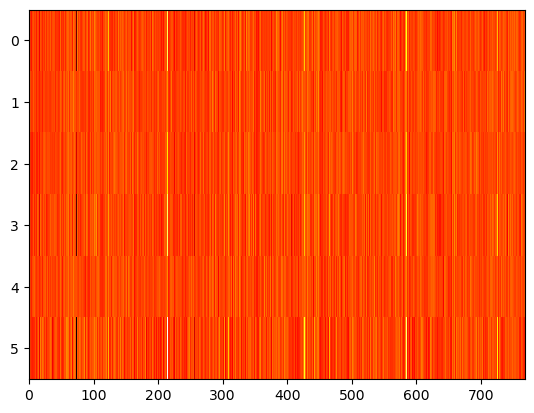

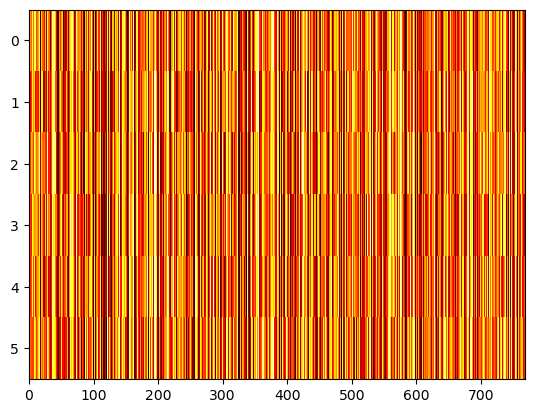

In [24]:
# Take a sample and do a forward pass through the model
sample = encoded_dataset["train"][1:7]
with torch.no_grad():
    output = model(data_collator(sample)["input_ids"].to(model.device))

print_outputinfo(output)

# Extract embeddings
average_embeddings = output.last_hidden_state.mean(-2)
average_embeddings = average_embeddings.detach().cpu().numpy()

pooled_embeddings = output.pooler_output
pooled_embeddings = pooled_embeddings.detach().cpu().numpy()

# A nicer plot can be produced using seabron.heatmap, but we forgot to add seaborn the the 
# dependencies :(
plt.imshow(average_embeddings, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

plt.imshow(pooled_embeddings, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

del sample, average_embeddings, pooled_embeddings

### Exercise 11: Feature Extraction Create a Dataset with Pooled Embeddings

We saw that the pooled embeddings look more promising.    
Therefore, write a function that extracts the pooled output.   
Making sure that
- gradient updates are disabled during the forward pass
- dropout is disabled (use the `eval()` method to put the model input evaluation mode)

Then apply this function to the dataset into a new column "extracted_features".

In [29]:
# Add your solution here:
# ...

#### Solution

In [30]:
import gc
gc.collect()

# We need to do this on the GPU to have reasonable speed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Push the mode to GPU
model.to(device)


def extract_feature_vectors(batch, model):
  """
  Function to extract features (aka embeddings) from a batch of samples.
  """
  # Set model into evaluation (inference) mode
  model.eval()
  # Forward pass through the model
  with torch.no_grad():
    output = model(data_collator(batch)["input_ids"].to(model.device))
  return {"extracted_features": output.pooler_output.detach().cpu().numpy()}

# Map the function to the dataset
encoded_dataset = encoded_dataset.map(lambda x: extract_feature_vectors(x, model), batched=True, batch_size=10)

encoded_dataset


  0%|          | 0/500 [00:00<?, ?ba/s]

### Exercise 12: Build and Train a Simple Classification Model

Create simple multi-class classification model that takes the pooled outputs as inputs and predicts the label.   

You can either build your own 1-Layer neural network using PyTorch and the `SequenceClassifierOutput` from `transformers.modeling_outputs` as output type for the model.   
Or use a linear regression (e.g., from `sklean.linear_model.LogisticRegression`).

In [ ]:
# Add your solution here:
# ...

#### Solution

In [ ]:
# SOLUTION FOR ML MODEL
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression(multi_class='multinomial')

X_train = encoded_dataset["train"]["extracted_features"]
y_train = encoded_dataset["train"]["label"]

X_test = encoded_dataset["test"]["extracted_features"]
y_test = encoded_dataset["test"]["label"]

lm.fit(X_train, y_train)

In [ ]:
# SOLUTION FOR NN

from transformers.modeling_outputs import SequenceClassifierOutput

class SimpleClassificationModel(torch.nn.Module):

  def __init__(self, hidden_dim, nr_labels, intermediate_dim=None):
    super().__init__()
    # Output dim
    self.num_labels = nr_labels
    # Output layer
    self.linear_layer = torch.nn.Linear(hidden_dim, nr_labels)


  def forward(self, input_ids, extracted_features, attention_mask=None, labels=None):
    # Calculate the logits from the linear layer
    # We use the extracted features as input to the model
    # The other inputs (input_ids and attention_masks) are not needed
    logits = self.linear_layer(extracted_features)

    # Loss calculation using cross entropy
    loss = None
    if labels is not None:
      loss_fct = torch.nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

    return SequenceClassifierOutput(
        loss=loss,
        logits=logits,
        hidden_states=None,
        attentions=None,
    )


# Run pass through the model
sample = encoded_dataset["train"][1:4]

simple_model = SimpleClassificationModel(hidden_dim = 768, nr_labels = len(keep_labels))
with torch.no_grad():
  simple_model(**data_collator(sample))


# Make sure dataset is suffled
encoded_dataset = encoded_dataset.shuffle(seed=1)

# Training arguments
training_args = TrainingArguments(
    output_dir="../checkpoints/feature_extraction",
    logging_dir='../logs/feature_extraction',
    learning_rate=2e-2,
    per_device_train_batch_size=len(encoded_dataset["train"]),
    per_device_eval_batch_size=len(encoded_dataset["test"]),
    evaluation_strategy="steps",
    logging_steps=5,
    eval_steps=5,
    num_train_epochs=80,
    weight_decay=0.01,
    save_steps=100
)

# Trainer
trainer = Trainer(
    model=simple_model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Use this if you have a checkpoint
#trainer.train(resume_from_checkpoint=True)
trainer.train()

### Exercise 13: Validate the Results

Predict a sample from the test set and compare it to the true labels (`ConfusionMatrixDisplay` from `sklearn` is a good tool to use for this.).   
The sample is used for illustration only (and to avoid OOM). In reality, we would of cause predict in whole test data in  batches.   

In [ ]:
sample = encoded_dataset["test"][1:100]

# Add your solution here:
# ...

#### Solution

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = lm.predict(X_test)

# Predict from the model (NN)
# with torch.no_grad():
#   outputs = simple_model(**data_collator(sample).to(device))
# y_test = np.array(sample["label"])
# y_pred = torch.argmax(outputs["logits"], dim=-1).cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize="true")
fix, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(cm, display_labels = list(lidx_to_label.values()))
disp.plot(ax=ax, cmap="Blues",colorbar=False)
plt.show()

### Exercise 14: Fine-Tune the Transformer Model End-to-End

We saw that our simple model with extracted embeddings as features does not perform very well.   
Therefore, we move forward to fine-tune the model on the task itself.

Huggingface Transformers has a nice feature for that:   
You don't need to build the model itself, or change the model's heads. Instead, you can make use of the `AutoModelForSequenceClassification` class that will take care of everything for you.

Below, you see an illustration on how the new model head will be finetuned together with all the other layers of the existing model.



In [ ]:
# Make some room in the memory
try:
    del model
    del simple_model
except:
    pass

# Add your solution here:
# ...

#### Solution

In [ ]:
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the device and the number of labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(keep_labels)

finetune_model = (AutoModelForSequenceClassification
                  .from_pretrained(model_name, num_labels=num_labels)
                  .to(device))

# Remove previously created columns and shuffle data
encoded_dataset = encoded_dataset.remove_columns(["extracted_features"])
encoded_dataset = encoded_dataset.shuffle(seed=1)

# Training arguments for fine-tuning
training_args = TrainingArguments(
    output_dir="../checkpoints/finetune",
    logging_dir="../logs/finetune",
    learning_rate=2e-5,
    per_device_train_batch_size=20,
    per_device_eval_batch_size=20,
    evaluation_strategy="steps",
    logging_steps=50,
    eval_steps=100,
    num_train_epochs=4,
    weight_decay=0.01,
    save_steps=500
)

# Trainer for fine-tuning
trainer = Trainer(
    model=finetune_model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Use this if you have a checkpoint
#trainer.train(resume_from_checkpoint=True)
trainer.train()
finetune_model.zero_grad()

# Predict the same sample as before
sample = encoded_dataset["test"][1:100]

# Run inference
with torch.no_grad():
  outputs = finetune_model(**data_collator(sample).to(device))

# True vs. predicted labels
y_true = np.array(sample["label"])
y_pred = torch.argmax(outputs["logits"], dim=-1).cpu().numpy()

print(y_true.shape)
print(y_pred.shape)

# Create confusion matrix as before
cm = confusion_matrix(y_true, y_pred, normalize="true")
fix, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(cm, display_labels = list(lidx_to_label.values()))
disp.plot(ax=ax, cmap="Blues",colorbar=False)
plt.grid(b=None)
plt.show()